In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import bernoulli


In [2]:
@dataclass
class Candle:
    open: float
    high: float
    close: float
    low: float
    index: int

@dataclass
class Stats:
    num_trades: int
    win_rate: float
    num_wins: int
    num_losses: int
    perc_return: float
    perc_buy_hold_return: float
    initial_cash: float
    total_profit: float

    def __repr__(self) -> str:
        return f"""
        Number of Trades: {self.num_trades}
        Win Rate: {self.win_rate}%
        Return [%] : {self.perc_return}%
        Buy and Hold Return [%]: {self.perc_buy_hold_return}%
        Total Profit: ${self.total_profit}
        Initial Capital: ${self.initial_cash}
        Winning Trades: {self.num_wins}
        Losing Trades: {self.num_losses}
        """


class Trade:
    def __init__(self, buy_price, buy_index, profit_perc, stop_loss_perc):

        self.buy_price = buy_price
        self.sell_price = None
        self.profit = None

        self.buy_index = buy_index
        self.sell_index = None

        self.profit_perc = profit_perc
        self.stop_loss_perc = stop_loss_perc

        self.is_closed = False

        self.take_profit_val = None
        self.take_stop_loss_val = None

        self.update()

    def update(self, curr_candle=None):

        self.take_profit_val = self.buy_price * (1 + self.profit_perc)
        self.take_stop_loss_val = self.buy_price * (1 - self.stop_loss_perc)

    def try_to_close(self, curr_candle):
        if self.is_closed:
            return False

        if curr_candle.low < self.take_stop_loss_val:
            self.close_trade(self.take_stop_loss_val, curr_candle.index)
            return True
        elif curr_candle.high > self.take_profit_val:
            self.close_trade(self.take_profit_val, curr_candle.index)
            return True

        return False


    def close_trade(self, sell_price, sell_index):
        self.sell_price = sell_price
        self.sell_index = sell_index
        self.profit = self.sell_price - self.buy_price

        self.is_closed = True


class BaseStrategy:
    def __init__(self, cash):
        self.all_trades = []
        self.cash = cash
        self.init_cash = cash
        # For buy and hold calculation
        self.init_buy_price = None
        self.buy_hold_cash = None
        self.final_buy_price = None

        self.final_stats = None


    def buy(self, buy_price, buy_index, profit_perc, stop_loss_perc):
        if buy_price > self.cash:
            return

        new_trade = Trade(buy_price, buy_index, profit_perc, stop_loss_perc)
        self.all_trades.append(new_trade)
        self.cash -= buy_price

    def _update_buy_hold_stats(self, curr_candle):
        if not self.init_buy_price:
            self.init_buy_price = curr_candle.open
            self.buy_hold_cash = self.cash - self.init_buy_price

        self.final_buy_price = curr_candle.close


    def run(self, curr_candle, row=None):
        self._update_buy_hold_stats(curr_candle)

        #raise ValueError("Must be implemented by other strategies")

    def force_close(self, curr_candle, row=None):
        for tr in self.all_trades:
            if not tr.is_closed:
                tr.close_trade(sell_price=curr_candle.close, sell_index=curr_candle.index)


    def get_stats(self):
        closed_trades = [tr for tr in self.all_trades if tr.is_closed]
        num_trades = len(closed_trades)
        num_wins = len([tr for tr in closed_trades if  tr.profit > 0])
        total_profit = sum([tr.profit for tr in closed_trades])
        if num_trades > 0:
            win_rate=(num_wins/num_trades) * 100.0
        else:
            win_rate = 0.0

        perc_return = total_profit*100.0/ self.init_cash
        perc_buy_hold_return = ((self.final_buy_price + self.buy_hold_cash) - self.init_cash)*100.0 / self.init_cash


        self.final_stats = Stats(
            num_trades=num_trades,
            num_wins=num_wins,
            num_losses=(num_trades - num_wins),
            win_rate=round(win_rate, 3),
            total_profit=total_profit,
            perc_return= round(perc_return, 3),
            initial_cash=self.init_cash,
            perc_buy_hold_return=round(perc_buy_hold_return, 3)
        )



class RandomStrategy(BaseStrategy):
    def __init__(self, cash):
        super().__init__(cash)

    def run(self, curr_candle, row):
        super().run(curr_candle, row)

        for tr in self.all_trades:
            close_curr = tr.try_to_close(curr_candle)
            if close_curr:
                self.cash += tr.sell_price

        curr_rv = self._get_random_num(state=curr_candle.index)
        if curr_rv:
            self.buy(
                buy_price = curr_candle.open,
                buy_index=curr_candle.index,
                profit_perc = 0.01,
                stop_loss_perc = 0.01,
            )

    def _get_random_num(self, prop=0.5, state=42):
        this_rv = bernoulli.rvs(prop, loc=0, size=1, random_state = state)[0]
        if this_rv == 1:
            return True
        else:
            return False


class MLStrategy(BaseStrategy):
    def __init__(self, cash, model, predictors):
        super().__init__(cash)
        self.model = model
        self.predictors = predictors
        self.current_prediction = None
        
    def run(self, curr_candle, row):
        super().run(curr_candle, row)
        
        # First check and close any existing trades
        for tr in self.all_trades:
            close_curr = tr.try_to_close(curr_candle)
            if close_curr:
                self.cash += tr.sell_price
        
        # Make prediction using the model
        features = row[self.predictors].values.reshape(1, -1)
        pred_proba = self.model.predict_proba(features)[:,1]
        prediction = 1 if pred_proba >= 0.6 else 0
        self.current_prediction = prediction
        
        # If model predicts price will go up (1) and we have enough cash, place a trade
        if prediction == 1:
            self.buy(
                buy_price=curr_candle.open,
                buy_index=curr_candle.index,
                profit_perc=0.01,  # 1% target profit
                stop_loss_perc=0.01,  # 1% stop loss
            )


def candlestick_ax(t, o, h, l, c):
    t_index = list(range(len(t)))

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    color = ["green" if close_price > open_price else "red" for close_price, open_price in zip(c, o)]
    ax.bar(x=t_index, height=h-l, bottom=l, width=0.1, color=color)
    ax.bar(x=t_index, height=np.abs(o-c), bottom=np.min((o,c), axis=0), width=0.6, color=color)


    t_loc = t_index[::72]
    #if type(t[0]) == datetime or type(t[0]) == pd._libs.tslibs.timestamps.Timestamp:
    #    label_loc = [datetime.strftime(x, '%H-%M') for x in t[::12]]
    label_loc = [x[:10] for x in t[::72]]
    ax.set_xticks(ticks=t_loc, labels=label_loc, rotation=45);

    return ax


class BackTest:
    def __init__(self, df, strategy):
        self.df = df
        self.strategy = strategy

    def run_test(self):
        for index, row in self.df.iterrows():
            curr_candle = Candle(open=row['Open'], close=row['Close'], high=row['High'], low=row['Low'], index=row['time_index'])
            self.strategy.run(curr_candle, row)
        self.strategy.force_close(curr_candle, row)

    def show_stats(self):
        self.strategy.get_stats()
        print(self.strategy.final_stats)


    def visualize(self, verbose=False):
        buy_list =[
            {'buy_time': tr.buy_index, 'sell_time': tr.sell_index, 'buy_price': tr.buy_price, 'sell_price': tr.sell_price,
             'profit': tr.profit}
            for tr in self.strategy.all_trades
        ]
        buy_sell_df = pd.DataFrame(buy_list)
        buy_sell_loss_df = buy_sell_df.query("profit<0")

        if verbose:
            print(buy_sell_df)

        _ax = candlestick_ax(t=self.df['time_str'], o=self.df['Open'], h=self.df['High'], l=self.df['Low'], c=self.df['Close'])
        _ax.plot(buy_sell_df['buy_time'], buy_sell_df['buy_price'], marker=".", markersize=40, color='g', alpha=0.3, linestyle="None")
        _ax.plot(buy_sell_df['sell_time'], buy_sell_df['sell_price'], marker=".", markersize=40, color='r', alpha=0.3, linestyle="None")
        _ax.plot(buy_sell_loss_df['sell_time'], buy_sell_loss_df['sell_price'], marker="x", markersize=20, color='k', alpha=0.3, linestyle="None")

        return _ax




## Test with some data

In [3]:
# file_id = '1rsYMnumxTHPyMlPJy45puDV0m7Y0Chxi'
# csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'
csv_path = '../resources/btc_07_24_08_24.csv'
# csv_path = '../data/ipo-dataset/2021/9/ACT.csv'

price_df = pd.read_csv(csv_path, on_bad_lines='warn')

In [4]:
len(price_df)

8924

In [5]:
price_df['time_index'] = price_df['loc_index']

In [6]:
price_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,time,time_str,loc_index,unix_time,Mid,time_index
0,65944.328125,65960.328125,65914.765625,65960.328125,0,0.0,0.0,2024-07-24 00:00:00+00:00,00-00,0,1.721779e+09,65937.546875,0
1,65979.828125,66002.625000,65979.828125,65999.710938,0,0.0,0.0,2024-07-24 00:05:00+00:00,00-05,1,1.721780e+09,65991.226562,1
2,66006.867188,66109.023438,66006.867188,66055.750000,43724800,0.0,0.0,2024-07-24 00:10:00+00:00,00-10,2,1.721780e+09,66057.945312,2
3,66045.406250,66045.406250,66007.835938,66007.835938,0,0.0,0.0,2024-07-24 00:15:00+00:00,00-15,3,1.721780e+09,66026.621094,3
4,66046.625000,66046.625000,65999.812500,66005.453125,0,0.0,0.0,2024-07-24 00:20:00+00:00,00-20,4,1.721780e+09,66023.218750,4


In [7]:
small_df = price_df.iloc[0:1000]

In [8]:
strategy = RandomStrategy(cash=70000)

In [9]:
this_backtest = BackTest(df=small_df, strategy=strategy)

In [10]:
this_backtest.run_test()

In [11]:
this_backtest.show_stats()


        Number of Trades: 15
        Win Rate: 66.667%
        Return [%] : 4.006%
        Buy and Hold Return [%]: 3.035%
        Total Profit: $2804.4847265624994
        Initial Capital: $70000
        Winning Trades: 10
        Losing Trades: 5
        


    buy_time  sell_time     buy_price    sell_price      profit
0          0        160  65944.328125  66603.771406  659.443281
1        160        226  66488.593750  65823.707812 -664.885938
2        226        277  65847.343750  65188.870313 -658.473437
3        279        301  65391.214844  64737.302695 -653.912148
4        302        457  64346.632812  63703.166484 -643.466328
5        458        461  63506.734375  64141.801719  635.067344
6        463        470  64231.519531  64873.834727  642.315195
7        471        544  64867.152344  65515.823867  648.671523
8        547        580  65548.781250  66204.269062  655.487812
9        580        605  66125.523438  66786.778672  661.255234
10       607        613  66738.164062  67405.545703  667.381641
11       613        744  67261.257812  67933.870391  672.612578
12       745        750  67893.562500  67214.626875 -678.935625
13       750        812  67248.609375  67921.095469  672.486094
14       812        999  67879.085938  6

<Axes: >

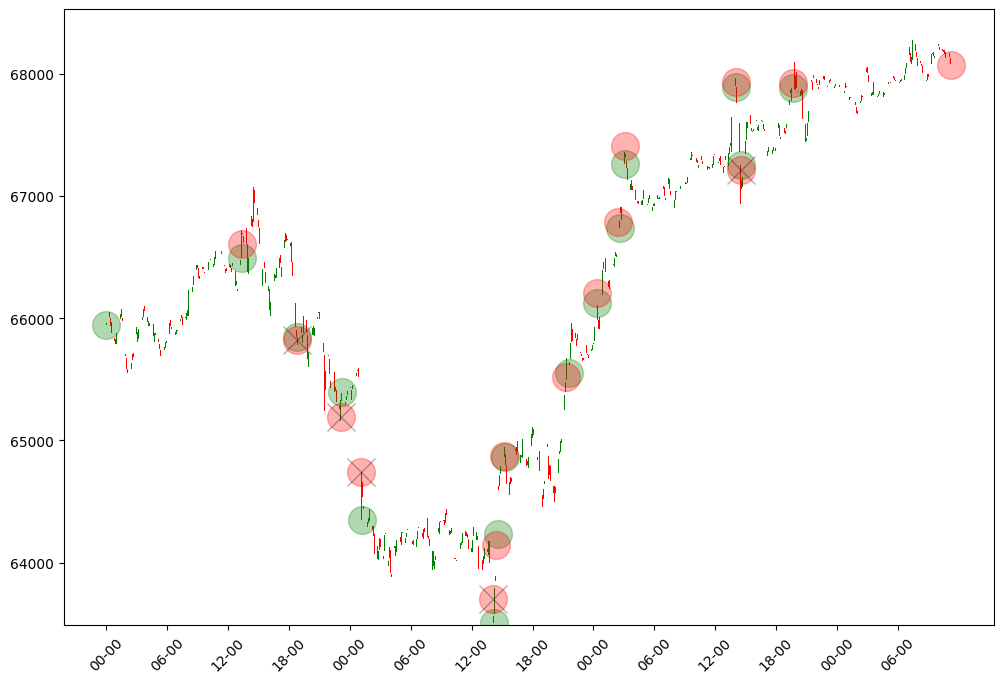

In [12]:
this_backtest.visualize(verbose=True)